### ABSTRACT

- Food insecurity remains a critical global challenge, affecting an estimated 2.3 billion people, with smallholder farming households among the most vulnerable. Over the years, extensive research has sought to understand the drivers of household food security. One key effort is the Rural Household Multi-Indicator Survey (RHOMIS), a standardized tool that collects detailed data on household demographics, farm characteristics, crop and livestock production, resource use, and key socio-economic and food security indicators. From over 750 variables, RHOMIS derives more than 40 aggregate indicators that capture welfare, productivity, and economic performance at the household level.

- Building on this rich dataset, our study aims to develop predictive models of household food security across multiple countries. By identifying the most influential factors associated with food security outcomes, we seek to provide insights that can support evidence-based interventions and inform policy decisions targeting vulnerable farming households.

    - Machine learning approaches offer potential for scalable identification of food insecure households to guide targeted interventions.

- Objective: To develop and evaluate machine learning models for binary food security classification using comprehensive household indicators from the RHoMIS dataset across 21 developing countries.

### METHODOLOGY
### Data Preparation and Preprocessing

1. Description: The RHoMIS dataset covers 13,310 farm households across 21 countries and was collected from 2015 to 2018
Feature Selection: We were able to Reduce the original features to 26 relevant variables after removing ID columns, and redundant indicators

2. Missing Data Handling:

    We noted that there were no rows within target variable (HFIAS_status), that had null values 
    
    We then applied median imputation for numerical features and used the most frequent value imputation for categorical features


3. Feature Engineering:
    
- Label encoding for categorical variables. The categorical values included:
        
    - HFIAS_status (The target variable) - Assigned the values [0, 1, 2, 3, 4] to the different categories

    - Country - One-hot encoding was used in labelling different countries
    
- StandardScaler for numerical features to handle different scales (income vs. household size)

4. Data Splitting: 80/20 train-test split with stratification to maintain class distribution

5. Machine Learning Pipeline
- Model Selection: 
    - This study analyzed 13,310 farm households (2015-2018) using four classification algorithms::

        - Random Forest 
        - XGBoost
        - LightGBM 
        - Logistic Regression. 

    - The target variable distinguished food secure from food insecure households.

6. Evaluation Metrics:
    - Primary: F1-macro score (equal treatment of all food security classes)
    - Secondary: Accuracy, Precision, and Recall for comprehensive assessment

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("RHoMIS_Indicators.csv", encoding='latin1')

df['Altitude'] = pd.to_numeric(df['Altitude'], errors='coerce')

- To remain with a clean dataset, we dropped columns having more than 50% missing values as well as columns we deemed not to be as impactful in predicting the target variable

- Some of the columns we will drop include:
    - ID_PROJ 
    - ID_COUNTRY 
    - YEAR 
    - ITERATION 
    - SURVEY_ID 
    - ID_HH

In [3]:
df_cleaned = df[['Country',
'Altitude',
'HFIAS_status',
'Food_Availability_kCal_MAE_day',
'PPI_Likelihood',
'PPI_Threshold',
'score_HDDS_farmbasedBadSeason',
'HHsizemembers',
'Gender_FemaleControl',
'LandOwned',
'LivestockHoldings',
'farm_income_USD_PPP_pHH_Yr',
'value_livestock_production_USD_PPP_pHH_Yr']]

print(f"\nDataFrame shape after dropping columns: {df_cleaned.shape}")


DataFrame shape after dropping columns: (13310, 13)


- We now plot the correlation heatmap to check for any numerical features that may have correlation >= 0.85 

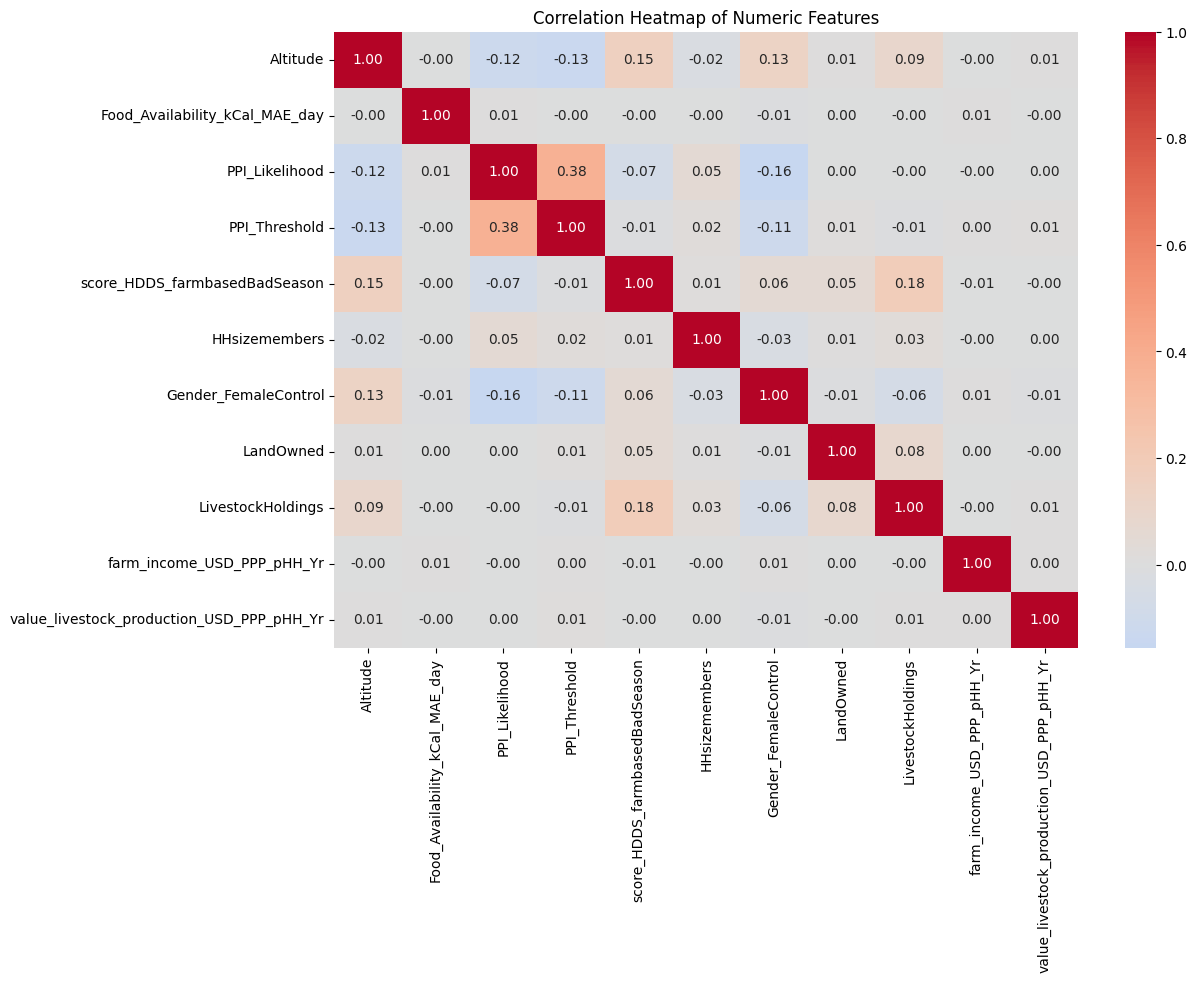

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# numeric features only
numeric_cols = df_cleaned.select_dtypes(include=['int64','float64']).columns

# correlation matrix
corr_matrix = df_cleaned[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

- Since there are no features with correlation >= 0.85, we can now proceed.

- Due to the unbalanced nature of 'HFIAS_status' categories, we can compress the four categories: FoodSecure, MildlyFI, ModeratelyFI, SeverelyFI to Secure and Insecure. This will in turn improve the performance of the model

In [5]:
df_cleaned["HFIAS_binary"] = df_cleaned["HFIAS_status"].apply(
    lambda x: "Secure" if x == "FoodSecure" else "Insecure"
)

df_cleaned['HFIAS_binary'].value_counts()

/tmp/ipykernel_18289/1514256723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["HFIAS_binary"] = df_cleaned["HFIAS_status"].apply(


HFIAS_binary
Insecure    8644
Secure      4666
Name: count, dtype: int64

- Next, we separated the target variable and the rest of the features followed up by splitting the dataset into training and testing portions, where 20% of the data was used for testing and 80% used for training as shown below

In [6]:
# Separate features and target
X = df_cleaned.drop(['HFIAS_status', 'HFIAS_binary'], axis=1)
y = df_cleaned['HFIAS_binary']

# Identify feature types
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


- We then Split the data followed by preprocessing 
    - Done in this order to prevent data leakage 

- Data leakage happens when information from outside the training dataset sneaks into the training process, giving the model access to data it shouldn’t have at prediction time.

In [7]:
# Splitting data and preprocessing 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (10648, 12)
Test set shape: (2662, 12)


- To handle the missing values, we opted to impute using the median values for numerical features and the most frequent for categorical features.

- It was done by creating a preprocessing pipeline that would be fitted to the data at a later stage

In [8]:
# Creating a preprocessing pipeline

# Numerical pipeline: Imputed with median, then scale
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Imputed with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])


 - This was followed up by the encoding process where we encoded the target variable using the label encoder

In [9]:
# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Target encodding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} --> {i}")

Target encodding mapping:
Insecure --> 0
Secure --> 1


- We then fit the preprocessing pipeline to apply the changes to the training and testing datasets

In [ ]:
# Fit preprocessing pipeline and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get full feature names
feature_names = preprocessor.get_feature_names_out()

print(f"\nProcessed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")
print(feature_names)


Processed training set shape: (10648, 31)
Processed test set shape: (2662, 31)
['numerical__Altitude' 'numerical__Food_Availability_kCal_MAE_day'
 'numerical__PPI_Likelihood' 'numerical__PPI_Threshold'
 'numerical__score_HDDS_farmbasedBadSeason' 'numerical__HHsizemembers'
 'numerical__Gender_FemaleControl' 'numerical__LandOwned'
 'numerical__LivestockHoldings' 'numerical__farm_income_USD_PPP_pHH_Yr'
 'numerical__value_livestock_production_USD_PPP_pHH_Yr'
 'categorical__Country_Burundi' 'categorical__Country_Cambodia'
 'categorical__Country_Costa_Rica' 'categorical__Country_DRC'
 'categorical__Country_El_Salvador' 'categorical__Country_Ethiopia'
 'categorical__Country_Ghana' 'categorical__Country_Guatemala'
 'categorical__Country_Honduras' 'categorical__Country_India'
 'categorical__Country_Kenya' 'categorical__Country_LaoPDR'
 'categorical__Country_Malawi' 'categorical__Country_Mali'
 'categorical__Country_Nicaragua' 'categorical__Country_Peru'
 'categorical__Country_Tanzania' 'catego

- Now, we can perform modelling on the data using the following algorithms

    - RandomForest
    - XGBoost
    - LightGBM
    - Logistic Regression

In [18]:
# 1. RandomForest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=42
)
rf.fit(X_train_processed, y_train_encoded)

y_pred = rf.predict(X_test_processed)
y_proba = rf.predict_proba(X_test_processed)

print("Random Forest Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))


Random Forest Results
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1729
           1       0.80      0.66      0.72       933

    accuracy                           0.82      2662
   macro avg       0.82      0.79      0.80      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.8789910095545567


In [13]:
# 2. XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    eval_metric="mlogloss", random_state=42
)
xgb.fit(X_train_processed, y_train_encoded)

y_pred = xgb.predict(X_test_processed)
y_proba = xgb.predict_proba(X_test_processed)

print("XGBoost Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))

XGBoost Results
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1729
           1       0.78      0.67      0.72       933

    accuracy                           0.82      2662
   macro avg       0.81      0.79      0.79      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.8718063399904659


In [14]:
# 3. LightGBM

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=200, num_leaves=31, learning_rate=0.1,
    random_state=42
)
lgbm.fit(X_train_processed, y_train_encoded)

y_pred = lgbm.predict(X_test_processed)
y_proba = lgbm.predict_proba(X_test_processed)

print("LightGBM Results")
print(classification_report(y_test_encoded, y_pred))
# For binary classification, use probabilities for the positive class
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))

[LightGBM] [Info] Number of positive: 3733, number of negative: 6915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 10648, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350582 -> initscore=-0.616481
[LightGBM] [Info] Start training from score -0.616481
LightGBM Results
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1729
           1       0.79      0.67      0.72       933

    accuracy                           0.82      2662
   macro avg       0.81      0.79      0.79      2662
weighted avg       0.82      0.82      0.82      2662

ROC AUC: 0.873506422499484


/home/jakes/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/jakes/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
# 4. logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train logistic regression with balanced class weights
logreg = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
logreg.fit(X_train_processed, y_train_encoded)

# Predictions
y_pred = logreg.predict(X_test_processed)

# Results
print("Logistic Regression Results")
print(classification_report(y_test_encoded, y_pred))
print("ROC AUC:", roc_auc_score(y_test_encoded, y_proba[:, 1]))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1729
           1       0.61      0.78      0.68       933

    accuracy                           0.75      2662
   macro avg       0.73      0.75      0.73      2662
weighted avg       0.77      0.75      0.75      2662

ROC AUC: 0.873506422499484
Confusion Matrix:
 [[1261  468]
 [ 209  724]]


| Model | Accuracy | Macro F1 | Food Inecure F1 | Food Secure F1 | ROC-AUC |
|-------|----------|----------|----------------|------------------|---------|
| Random Forest | 0.82 | 0.80 | 0.87 | 0.72 | 0.879 |
| XGBoost | 0.82 | 0.79 | 0.87 | 0.72 | 0.872 |
| LightGBM | 0.82 | 0.79 | 0.87 | 0.72 | 0.874 |
| Logistic Regression | 0.75 | 0.73 | 0.79 | 0.68 | 0.874 |


### Results:

Modelling
- Random Forest achieved optimal performance with 82% accuracy, 0.80 macro F1-score, and 0.879 ROC-AUC. 
    - The model demonstrated strong identification of food insecure households (91% recall, 87% F1-score) and reasonable precision for food secure households (78% precision, 72% F1-score). 

- All tree-based ensemble methods showed consistent performance, while class imbalance resulted in lower recall (67%) for the food secure minority class.

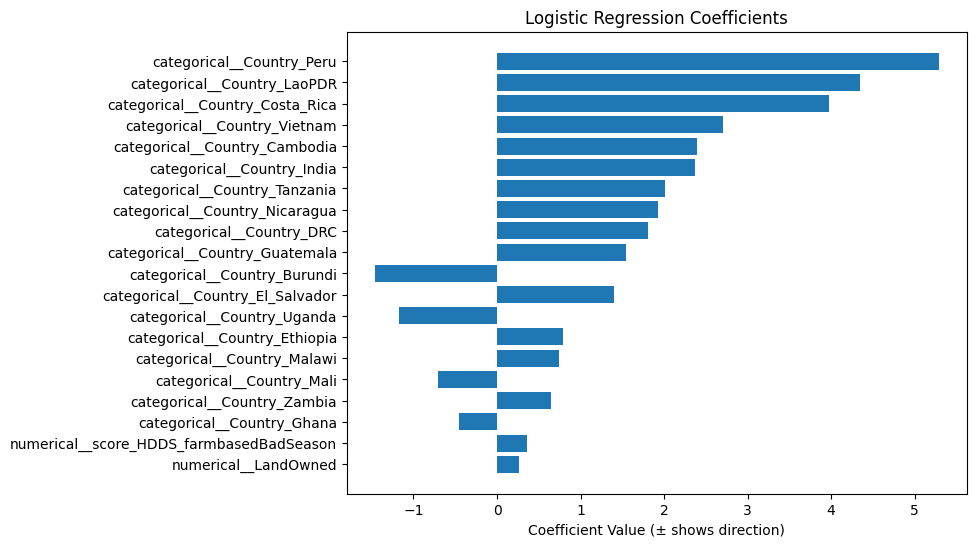

In [27]:
def plot_logreg_coefficients(model, feature_names, top_n=20):
    coef = model.coef_[0]  # binary classification
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coef,
        "abs_coef": abs(coef)
    })
    coef_df = coef_df.sort_values(by="abs_coef", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(coef_df["feature"], coef_df["coefficient"])
    plt.gca().invert_yaxis()
    plt.title("Logistic Regression Coefficients")
    plt.xlabel("Coefficient Value (± shows direction)")
    plt.show()

# Example usage
plot_logreg_coefficients(logreg, feature_names)

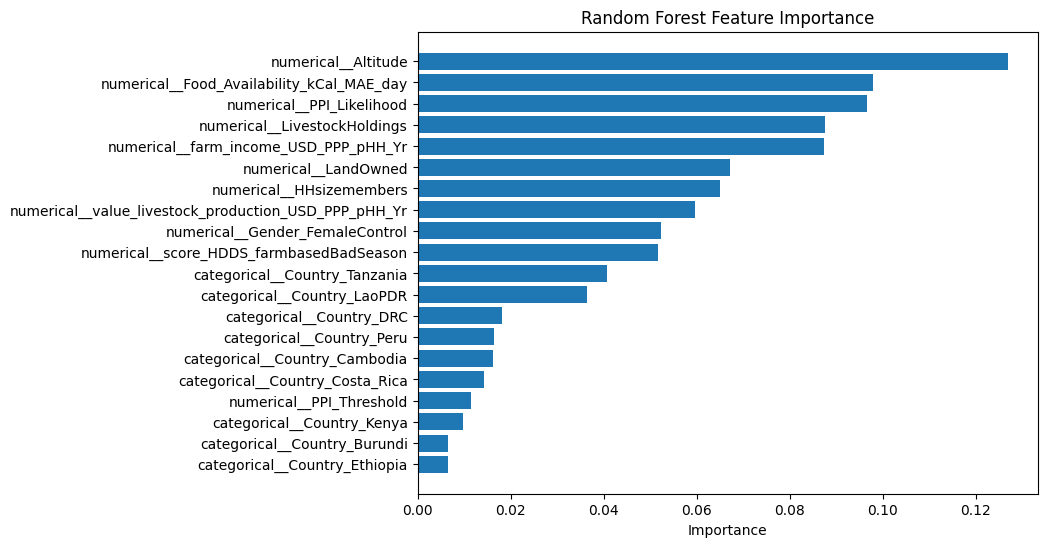

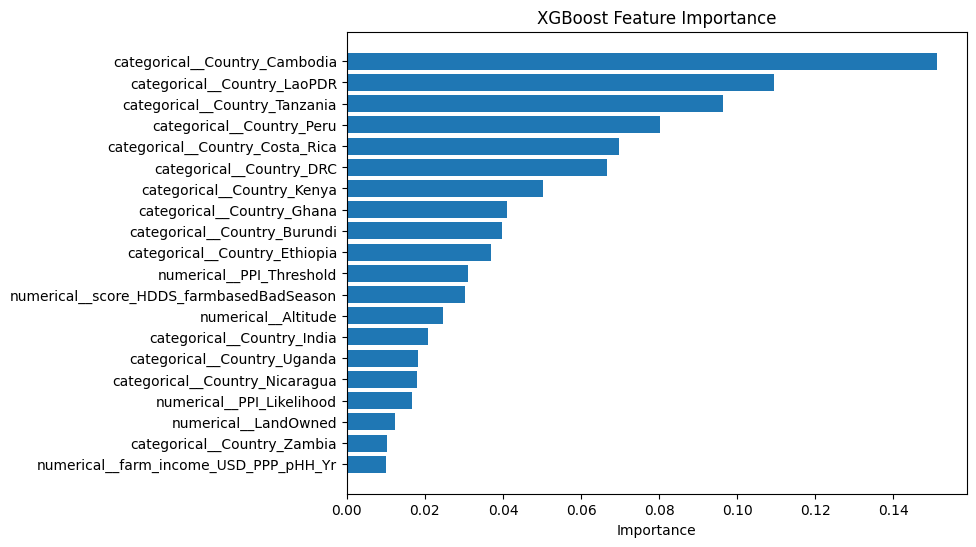

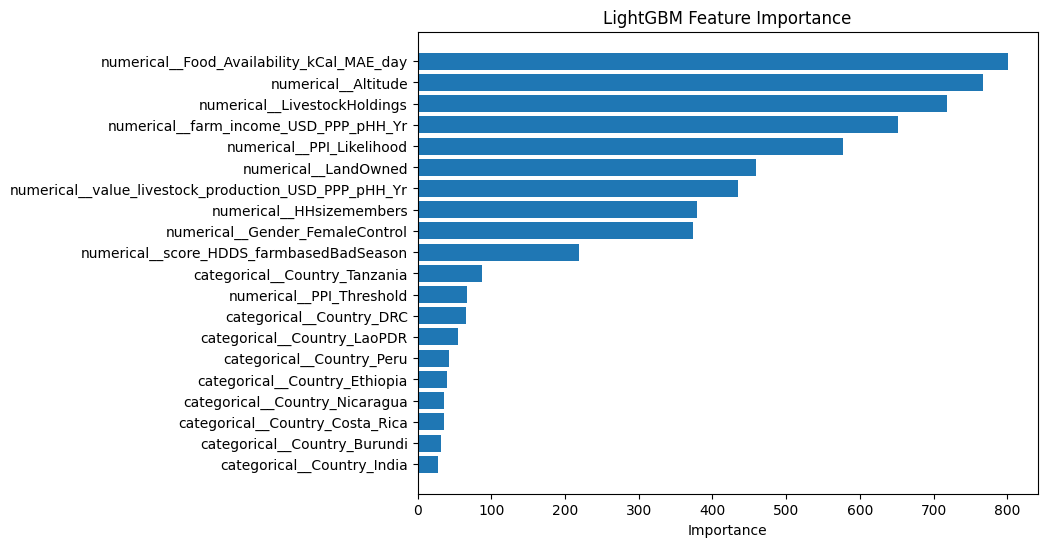

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_importance(model, feature_names, top_n=20, title="Feature Importance"):
    importances = model.feature_importances_
    feat_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    feat_df = feat_df.sort_values(by="importance", ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    plt.barh(feat_df["feature"], feat_df["importance"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.show()
    # print(feat_df)

plot_feature_importance(rf, feature_names, title="Random Forest Feature Importance")
plot_feature_importance(xgb, feature_names, title="XGBoost Feature Importance")
plot_feature_importance(lgbm, feature_names, title="LightGBM Feature Importance")


### Discussion

- The divergence between models reveals the multi-layered nature of food security - both geographic context and household assets matter
- Altitude emerges as an unexpected universal predictor, highlighting the role of geographic accessibility in food security
- XGBoost identifies Cambodia and Lao PDR as critical predictors, suggesting region-specific food security challenges

##### Model Interpretation Insights
1. Why XGBoost Differs: 
- The technical explanation is that XGBoost's Country Emphasis Suggests:
    - Interaction Effects: Country variables capture complex interactions other models miss
    - Non-linear Patterns: Geographic factors have threshold effects
    - Feature Selection Bias: Gradient boosting may overweight categorical features with many categories

2. Random Forest & LightGBM Agreement Indicates:
    - Robust Household Factors: These variables consistently predict across different algorithms
    - Universal Patterns: Altitude, food availability, and livestock matter regardless of methodology
    - Practical Predictors: These factors are directly observable and actionable

- Therefore, the models reveal two complementary targeting strategies:
    - Geographic screening (XGBoost): Use country/region for initial resource allocation
    - Household screening (RF/LightGBM): Use individual factors for final targeting


### Conclusions: 
- Machine learning models can effectively support food security screening programs with 82% accuracy suitable for policy applications. 
- The Random Forest model provides a robust foundation for identifying households requiring intervention, though strategies to improve detection of food secure households should be explored. 
- This framework offers scalable assessment capability for food security programs across developing countries.

Citation

van Wijk, M., Hammond, J., Gorman, L. et al. (2019). The Rural Household Multiple Indicator Survey (RHoMIS) data of 13,310 farm households in 21 countries. https://doi.org/10.7910/DVN/9M6EHS, Harvard Dataverse, V3, UNF:6:ZnVw+OfivEtIKcZWC9iwgw== [fileUNF]

References
https://www.ilri.org/knowledge/publications/rural-household-multiple-indicator-survey-rhomis-data-13310-farm-households